<a href="https://colab.research.google.com/github/chirun76/WongKinYiu.yolov7/blob/main/lilin%20modify/yolov7toamba_tipVersion_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 共用區
---
## Part 1 : 環境安裝

In [1]:
# 安裝所需套件
!pip install --upgrade setuptools pip --user    # 更新 setuptools 和 pip
!pip install onnx                               # 安裝 ONNX
!pip install onnxruntime                        # 安裝 ONNX runtime
#!pip install --ignore-installed PyYAML         # 可選：強制重裝 PyYAML（此行已被註解）
#!pip install Pillow                            # 可選：安裝 Pillow（此行已被註解）

!pip install protobuf<4.21.3                    # 安裝 protobuf 特定版本，兼容性更新
!pip install onnxruntime-gpu                    # 安裝 ONNX GPU 版
!pip install onnx>=1.9.0                        # 安裝 ONNX 1.9.0 及以上版本
!pip install onnx-simplifier>=0.3.6 --user      # 安裝 ONNX 模型簡化工具

  Using cached onnx-1.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
Using cached onnx-1.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
/bin/bash: line 1: 4.21.3: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 25.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0], sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
Pytorch version: 2.5.0+cu121
/bin/bash: line 1: nvidia-smi: command not found
Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 27.49 MiB/s, done.
Resolving deltas: 100% (520/520), done.
/content/yolov7
cfg	detect.py  hubconf.py  models	  requirements.txt  tools	  u

## Part 2 : 確認系統環境

In [ ]:
# 檢查 Python 和 PyTorch 版本
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info}")
print(f"Pytorch version: {torch.__version__}")
!nvidia-smi  # 檢查 NVIDIA GPU 可用性

## Part 3 : 下載 Yolov7 檔案與權重

In [ ]:
# 下載 YOLOv7 代碼
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7

# 檢查 yolov7 目錄中的文件
!ls

# 下載預訓練權重文件
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

## Part 4 : 利用下載的權重進行物件檢測

In [ ]:
# 使用 YOLOv7 進行檢測
!python detect.py --weights ./yolov7-tiny.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg
from PIL import Image
Image.open('/content/yolov7/runs/detect/exp/horses.jpg')  # 顯示檢測結果圖像

## Part 5 : 匯出 Yolo 模型 [onnx] 格式

In [ ]:
# 將模型匯出為 ONNX 格式
%cd /content/yolov7/
!python export.py --weights ./yolov7-tiny.pt \
        --grid --end2end --simplify \
        --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 \
        --img-size 640 640 --max-wh 640  # 匯出 ONNX 模型，設置各種參數

# 檢查匯出的 ONNX 模型
!ls

## Part 6 : 進行模型推論

In [ ]:
# ONNX 模型推論
import cv2
cuda = True  # 使用 GPU，如果可用
w = "/content/yolov7/yolov7-tiny.onnx"
img = cv2.imread('/content/yolov7/inference/images/horses.jpg')  # 加載輸入圖像

# 匯入所需的庫
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple

# 設定推論設備：CUDA 或 CPU
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)  # 創建推論會話

# 定義圖像預處理函數：調整尺寸並添加邊框
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    shape = im.shape[:2]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:
        r = min(r, 1.0)

    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    if auto:
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)

    dw /= 2
    dh /= 2

    if shape[::-1] != new_unpad:
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im, r, (dw, dh)

# 設置分類名稱和顏色
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush']
colors = {name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)}

# 圖像預處理：轉換顏色、調整大小
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

# 標準化圖像
im = image.astype(np.float32)
im /= 255

# 獲取模型輸入輸出名稱
outname = session.get_outputs()[0].name
input_name = session.get_inputs()[0].name

# 執行推論
outputs = session.run([outname], {input_name: im})[0]

## Part 7 : 繪製結果

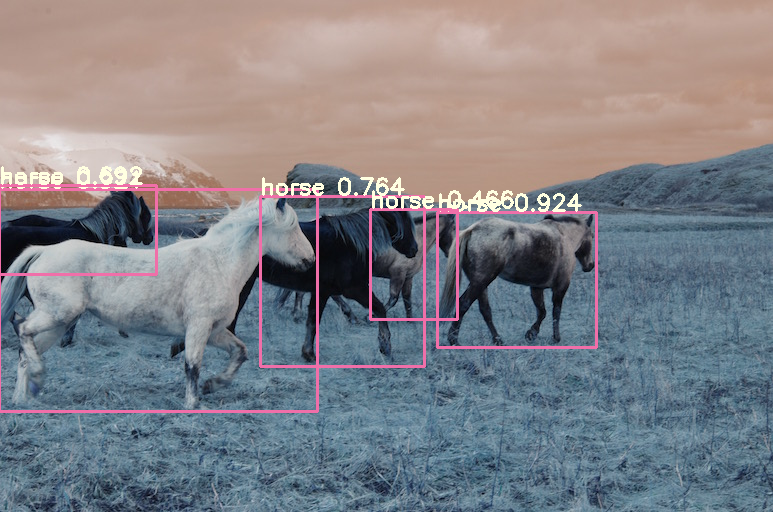

In [3]:

# 從輸出生成標註圖像
ori_images = [img.copy()]
for i, (batch_id, x0, y0, x1, y1, cls_id, score) in enumerate(outputs):
    image = ori_images[0]
    box = np.array([x0, y0, x1, y1])
    box -= np.array(dwdh * 2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score), 3)
    name = names[cls_id]
    color = colors[name]
    name += ' ' + str(score)
    cv2.rectangle(image, box[:2], box[2:], color, 2)
    cv2.putText(image, name, (box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)

# 顯示標註後的圖像
image_rgb = cv2.cvtColor(ori_images[0], cv2.COLOR_BGR2RGB)
Image.fromarray(image_rgb)

---

# 以下是推論修改後的 onnx 檔

In [17]:
import onnx
import onnxruntime
import numpy as np
import cv2
import sys
from PIL import Image
import time


# 80 COCO classes
CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
           'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
           'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
           'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
           'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
           'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
           'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
           'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
           'hair drier', 'toothbrush']

## Self-defined classes
# meta = sess.get_modelmeta().custom_metadata_map
# print( meta )
# 加載並檢查 ONNX 模型
def load_onnx(onnx_path):
    onnx_model = onnx.load(onnx_path)
    try:
        onnx.checker.check_model(onnx_model)
    except Exception:
        print("Model incorrect")
    else:
        print("Model correct")

    # 設定模型推理選項
    options = onnxruntime.SessionOptions()
    sess = onnxruntime.InferenceSession(onnx_path,
                                        providers=['CPUExecutionProvider'])
    # 'CUDAExecutionProvider',
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    print(input_name,output_name)
    return sess,input_name,output_name

# 使用 ONNX 模型進行推理
def onnx_inference(sess,input_name,output_name,data):
    # 對數據進行推理並返回結果
    pred_onnx = sess.run([output_name], {input_name: data})
    return pred_onnx

# 調整影像尺寸以適應模型輸入
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
 	# Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

# 計算兩個框的 IOU（交集比聯合）
def box_iou(box1, box2, eps=1e-7):
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (np.min(a2, b2) - np.max(a1, b1)).clamp(0).prod(2)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

# 將 (x, y, w, h) 轉換為 (x1, y1, x2, y2)
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

# 非極大值抑制（NMS）來過濾重疊的框
def nms_boxes(boxes, scores):

    x = boxes[:, 0]
    y = boxes[:, 1]
    w = boxes[:, 2] - boxes[:, 0]
    h = boxes[:, 3] - boxes[:, 1]

    areas = w * h
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x[i], x[order[1:]])
        yy1 = np.maximum(y[i], y[order[1:]])
        xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
        yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 0.00001)
        h1 = np.maximum(0.0, yy2 - yy1 + 0.00001)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= 0.45)[0]

        order = order[inds + 1]
    keep = np.array(keep)
    return keep

# 非極大值抑制的主函數
def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv7 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates


    # Settings
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    mi = 5 + nc  # mask start index
    output = [np.zeros((0, 6 + nm))] * bs

    for xi, x in enumerate(prediction):  # image index, image inference
        x = x[xc[xi]]  # confidence
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = np.zeros(len(lb), nc + nm + 5)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = np.concatenate((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box/Mask
        box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = np.concatenate((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)

        else:  # best class only
            conf = np.max(x[:, 5:mi], 1).reshape(box.shape[:1][0], 1)
            j = np.argmax(x[:, 5:mi], 1).reshape(box.shape[:1][0], 1)
            x = np.concatenate((box, conf, j, mask), 1)[conf.reshape(box.shape[:1][0]) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == np.array(classes, device=x.device)).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        index = x[:, 4].argsort(axis=0)[:max_nms][::-1]
        x = x[index]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = nms_boxes(boxes, scores)
        i = i[:max_det]  # limit detections

        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = np.multiply(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output

def clip_boxes(boxes, shape):
    # Clip boxes (xyxy) to image shape (height, width)

    boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    # Rescale boxes (xyxy) from img1_shape to img0_shape
    # calculate from img0_shape
    if ratio_pad is None:
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    boxes[..., [0, 2]] -= pad[0]  # x padding
    boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes


# 繪製結果框和標籤
def draw(image, box_data):
    boxes = box_data[..., :4].astype(np.int32)  # x1 x2 y1 y2
    scores = box_data[..., 4]
    classes = box_data[..., 5].astype(np.int32)
    for box, score, cl in zip(boxes, scores, classes):
        top, left, right, bottom = box
        print('class: {}, score: {}'.format(CLASSES[cl], score))
        print('box coordinate left,top,right,down: [{}, {}, {}, {}]'.format(top, left, right, bottom))

        cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
        cv2.putText(image, '{0} {1:.2f}'.format(CLASSES[cl], score),
                    (top, left),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 2)
    return image

# 主函數進行推理和結果顯示
def main():
    onnx_path = "/content/yolov7/YOLOv7_tiny_subgraph.onnx"
    img_path = "/content/yolov7/inference/images/horses.jpg"

    sess,input_name,output_name = load_onnx(onnx_path)
    imgsz = (640, 640)
    img = cv2.imread(img_path)
    print(img.shape)
    # preprocess
    im = letterbox(img, new_shape=imgsz, auto=False)[0]  # padded resize
    im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    im = np.ascontiguousarray(im)  # contiguous
    im = im.astype(np.float32)
    im /= 255  # 0 - 255 to 0.0 - 1.0

    if len(im.shape) == 3:
        im = np.expand_dims(im, axis=0)

    # im =  im.reshape(1, 3, 640, 640).astype(np.float32)
    pred = onnx_inference(sess,input_name,output_name, im)

    # NMS
    conf_thres = 0.65  # confidence threshold
    iou_thres = 0.65  # NMS IOU threshold
    max_det = 640  # maximum detections per image
    classes = None  # filter by class: --class 0, or --class 0 2 3
    agnostic_nms = False  # class-agnostic NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)


    # Process predictions
    seen = 0
    for i, det in enumerate(pred):
        seen += 1
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], img.shape).round()
    # print(pred)
    outputs = pred[0][:, :6]

    draw(img,outputs)
    cv2.imwrite('./car_output_onnx.jpg', img)

    return


if __name__ == "__main__":
    main()


Model correct
images /model/model.77/Concat_3_output_0
(512, 773, 3)
class: horse, score: 0.923836886882782
box coordinate left,top,right,down: [437, 212, 596, 347]
class: horse, score: 0.9210648536682129
box coordinate left,top,right,down: [0, 189, 317, 411]
class: horse, score: 0.7638463973999023
box coordinate left,top,right,down: [260, 196, 424, 366]
class: horse, score: 0.6917027235031128
box coordinate left,top,right,down: [0, 185, 156, 273]


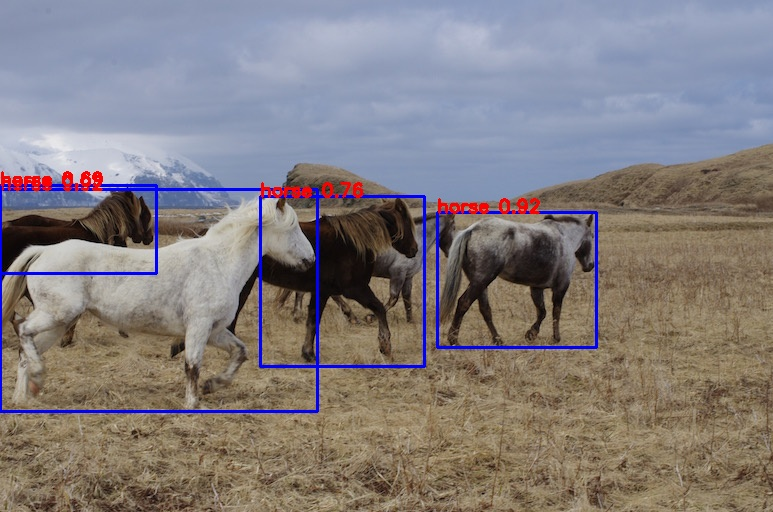

In [19]:
Image.open('./car_output_onnx.jpg')

# 以下是驗證 IPCAM 的推論輸出 bin 檔

In [ ]:
import numpy as np
import cv2

def read_bin_as_float(filename):
    # 讀取二進位檔案，並將數據以 float32 類型載入
    with open(filename, "rb") as f:
        data = np.fromfile(f, dtype=np.float32)

    data = data.reshape((1, 25200, 85))
    return data

filename = "/content/output.bin"
pred = read_bin_as_float(filename)

for i in range(85):
  print(pred[0][10000][i])

# 影像預處理：將影像縮放至指定大小並填充邊界，保持寬高比

img_path = "/content/bus_640.jpg"
imgsz = (640, 640)
img = cv2.imread(img_path)
print(img.shape)
# preprocess
im = letterbox(img, new_shape=imgsz, auto=False)[0]  # padded resize
im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
im = np.ascontiguousarray(im)  # contiguous
im = im.astype(np.float32)
im /= 255  # 0 - 255 to 0.0 - 1.0

# 若影像為三維，增加一個維度，將其調整為四維 (batch size, channels, height, width)
if len(im.shape) == 3:
  im = np.expand_dims(im, axis=0)

# NMS（非極大值抑制）的設定參數
conf_thres = 0.35  # confidence threshold
iou_thres = 0.65  # NMS IOU threshold
max_det = 640  # maximum detections per image
classes = None  # filter by class: --class 0, or --class 0 2 3
agnostic_nms = False  # class-agnostic NMS

# 使用 NMS 過濾預測結果，篩選出置信度較高且重疊較少的預測框
pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# 處理 NMS 後的預測框
seen = 0
for i, det in enumerate(pred):
  seen += 1
  if len(det):
      # 將預測框從縮放後的影像大小調整回原影像大小
      det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], img.shape).round()
# 輸出預測結果的前六個參數 (x_min, y_min, x_max, y_max, conf, class)
outputs = pred[0][:, :6]

# 將結果儲存到指定路徑
draw(img,outputs)
cv2.imwrite('/content/bus_640_output.jpg', img)

FileNotFoundError: [Errno 2] No such file or directory: '/content/output.bin'

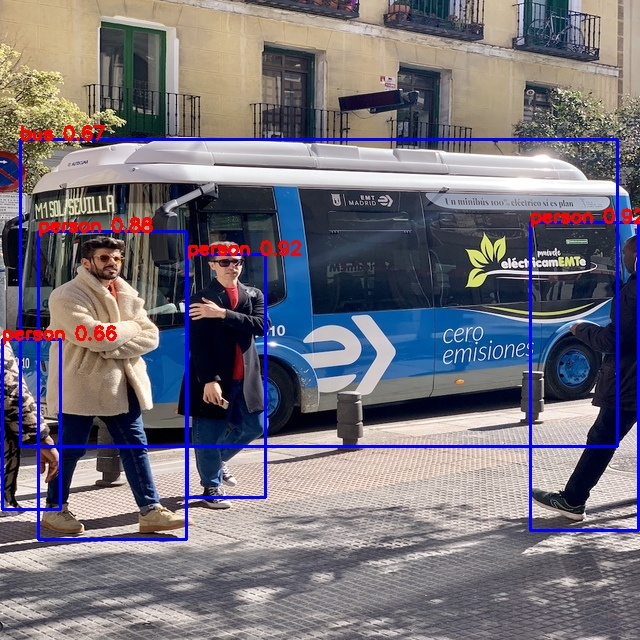

In [ ]:
Image.open('/content/bus_640_output.jpg')